# Modelo

## Objetivo del Modelo: Estimar el efecto de una candidata mujer para el partido
## p  ∈ {PAN, PRI, MORENA} en la probabilidad P() de ganar un distrito

### ____ 1) Scraper nombres
    
    El objetivo de esta sección es minar la información de nombres de bebé 
    para determinar, a partir de los nombres de candidatos, si éstos fueron
    hombres o mujeres:
    
    Source: https://www.planetamama.com.ar/nombres-de-bebes/buscar/todos/sexo/todos/origen/todos?page=0

In [1]:
import json
import pandas as pd
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt 
import unicodedata
import statsmodels.api as sm
import winsound
frequency = 300
duration = 500

In [ ]:
page = 'https://www.planetamama.com.ar/nombres-de-bebes/buscar/todos/sexo/todos/origen/todos?page={}'

In [ ]:
base_datos = {'Mujer': [], 'Varón': [], 'Indistinto': []}
for i in range(137):
    page_i = page.format(i)
    html = urlopen(page_i).read()
    soup = BeautifulSoup(html, "lxml")
    raw = soup.get_text()
    raw = re.split(r'[\t\n\r\xa0]+', raw)
    origen_y_significado_index = raw.index('Origen y Significado') + 1
    paginacion_index = raw.index('Paginación') - 1
    raw = raw[origen_y_significado_index: paginacion_index]
    raw = [s.strip() for s in raw]
    raw = [s for s in raw if s != 'Ver']
    for ii, nombre in enumerate(raw):
        try:
            if nombre not in ['Varón', 'Mujer', 'Indistinto']:
                base_datos[raw[ii + 1]].append(nombre) 
        except:
            pass
    print(i, end="\r", flush=True)
print('\nDone!')
winsound.Beep(frequency, duration)

In [ ]:
def strip_accents(text):
    '''
    Esta función quita los acentos
    '''
    try:
        text = unicode(text, 'utf-8')
    except NameError: 
        pass
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

In [ ]:
# Este proceso deja una base de nombres limpia
base_datos_nombres = {'Mujer': [], 'Varón': []}
for k, v in base_datos.items():
    if k != 'Indistinto':
        for nombre in v:
            nombre = strip_accents(nombre)
            nombre = nombre.upper()
            base_datos_nombres[k].append(nombre)

In [ ]:
with open('base_datos_nombres.json', 'w') as f:
    json.dump(base_datos_nombres, f, indent=4)

In [2]:
def is_mujer(nombre):
    '''
    Esta función, dado un nombre, determina si
    el candidato fue hombre (0) o mujer (1)
    '''
    nombre_list = nombre.split(' ')
    count_hombres = 0
    count_mujeres = 0
    for w in nombre_list:
        if w in base_datos_nombres['Mujer']:
            count_mujeres += 1
        else:
            pass
        if w in base_datos_nombres['Varón']:
            count_hombres += 1
        else:
            pass
    if count_mujeres >= count_hombres:
        rv = 1
    else:
        rv = 0
    return rv

In [3]:
with open('./base_datos_nombres.json', 'r') as f:
    base_datos_nombres = json.load(f)

In [73]:
distritos = pd.read_csv('distritos_2018_2015.csv', encoding='latin1')
distritos = distritos.fillna('SIN/DATOS')

In [74]:
# Este proceso inserta una columna con la variable dicotómica hombre (0), mujer (1)
distritos['candidato_pan_mujer'] = distritos['candidato_pan'].apply(is_mujer)
distritos['candidato_pri_mujer'] = distritos['candidato_pri'].apply(is_mujer)
distritos['candidato_morena_mujer'] = distritos['candidato_morena'].apply(is_mujer)

In [75]:
# Este proceso inserta una columna con la variable dicotómica 1 si el partido ganó el distrito 0 otherwise
for partido in ['PAN', 'PRI', 'MORENA']:
    y_partido = []
    for i in range(len(distritos)):
        p_g = distritos['ganador_2018'][i]
        if p_g == partido:
            y_partido.append(1)
        else:
            y_partido.append(0)
    distritos['y_{}'.format(partido.lower())] = y_partido

In [40]:
distritos_dto = distritos.loc[(distritos['entidad'] == 11) & (distritos['distrito'] == 4)]
distritos_dto = distritos_dto.reset_index(drop=True)

In [43]:
distritos_dto['diff_pan'][0]

0.078946823

### ___ 2) Estimar modelo

In [ ]:
p = alpha + bmujer + bpobreza + b(voto2018 - voto2015) + u

a) $$y_{i}^{p} = G(\alpha^{p} + \beta_{1}^{p}*mujer_{i}^{p} + \beta_{2}^{p}*pobreza_{i}^{p} + \beta_{3}^{p}*voto2015_{i}^{p} + u_{i})$$

b) $$y_{i}^{p} = G(\alpha + \beta_{1}*mujer_{i}^{p} + \beta_{2}*pobreza_{i}^{p} + \beta_{3}*(voto2018_{i}^{p} - voto2015_{i}^{p}) + u_{i})$$

$Y_{i}^{p} = 1$ Si el partido $p$ ganó o no el distrito $i$

$mujer_{i}^{p}$ 1 si el candidato del partido $p$ fue mujer en el $distrito_{i}$

$pobreza_{i}$ Pobreza en el $distrito_{i}$ como porcentaje de la población total

$(voto2018_{i}^{p} - voto2015_{i}^{p})$ Diferencial de votación para el partido $p$ en el distrito $i$

$G(*) no son lineales en los parámetros$i$

# Preguntas

    0. Estimar las dos versiones del modelo (el DataFrame ya trae columnas diff_partido
    (por ejemplo diff_pan) que son la diferencia expresada en:

$$voto2018_{i}^{p} - voto2015_{i}^{p}$$
    
    Para estimar el modelo aquí está la documentación de python:
    
    https://www.statsmodels.org/devel/generated/statsmodels.formula.api.logit.html
    
    1. Cómo interpretar b1 dado que mujer es dicotómica

    2. Cuál efecto de ser mujer en la probabilidad de ganar el distrito para cada partido
    (elaborar respuesta)

    3. Qué es y cómo interpretar una pseudo_R2 (sobre todo QUÉ ES?)

    4. Bonus algunos descriptivos del modelo

In [78]:
partido = 'morena'
Y = distritos['y_{}'.format(partido)]
X = distritos[['candidato_{}_mujer'.format(partido),
               'pobreza_2015_%', 'diff_{}'.format(partido)]]
X = sm.add_constant(X)
model = sm.Logit(Y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.297282
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               y_morena   No. Observations:                  300
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.4747
Time:                        07:51:47   Log-Likelihood:                -89.185
converged:                       True   LL-Null:                       -169.79
Covariance Type:            nonrobust   LLR p-value:                 1.004e-34
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6.9749      1.006     -6.935      0.000      -8.946      

    Given modern computers, from a practical perspective the most difficult aspect of
    logit or probit models is presenting and interpreting the results.

# $\beta_{i}$ es el $Δ$ en $P(Y=1|X)$ para un $Δ$ en $X_{i}?$

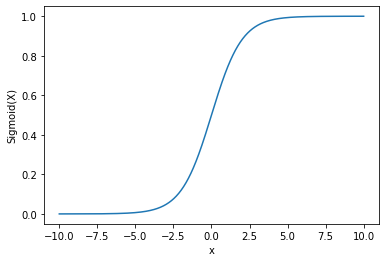

In [84]:
x = np.linspace(-10, 10, 1000) 
z = 1/(1 + np.exp(-x)) 
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 
  
plt.show() 

a) $$y_{i}^{p} = G(\alpha + \beta_{1}*mujer_{i}^{p} + \beta_{2}*pobreza_{i}^{p} + \beta_{3}*voto2015_{i}^{p} + u_{i})$$

b) $$y_{i}^{p} = G(\alpha + \beta_{1}*mujer_{i}^{p} + \beta_{2}*pobreza_{i}^{p} + \beta_{3}*(voto2018_{i}^{p} - voto2015_{i}^{p}) + u_{i})$$

$y_{i}^{p}$ no es lineal en $\beta$

Si $x_{i}$ es (roughly) continua:

$Δ\hat{P}(y=1|X)\approx [g(\hat{\beta_{0}} + X\hat{\beta_{1}})\beta_{i}]Δx_{i}$

$Δ\hat{P}(y=1|X)\approx [g(\hat{\beta_{0}} + \overline{X}\hat{\beta_{1}})\beta_{i}]Δx_{i}$

$$g(z) = \frac{e^{z}}{[1 + e^{z}]^{2}}$$

Tarea (págs 589-596 Wooldridge):

### average partial effect (APE)
### Odds ratio para $x_{i}$ discretas

# Validación

### ___predict (in sample)

# predict in-sample vs out-of-sample?

In [132]:
partido = 'morena'
Y = distritos['y_{}'.format(partido)]
X = distritos[['candidato_{}_mujer'.format(partido),
               'pobreza_2015_%', 'diff_{}'.format(partido)]]
X = sm.add_constant(X)
model = sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.297282
         Iterations 8


In [133]:
Y_hat_ps = model.predict(X)

In [135]:
suma_correct = 0
suma_y_1 = 0
threshold = distritos['y_{}'.format(partido)].sum() / 300
for i in range(300):
    true_y = distritos['y_{}'.format(partido)][i]
    y_hat_p = Y_hat_ps[i]
    if y_hat_p >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    if true_y == y_hat:
        suma_correct += 1
    suma_y_1 += y_hat
    print(true_y, y_hat, end=' | ')
print('Fitness:', suma_correct / 300)
print(distritos['y_{}'.format(partido)].sum())
print(suma_y_1)

0 0 | 1 0 | 0 0 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 0 | 1 1 | 0 0 | 1 1 | 1 1 | 0 0 | 0 0 | 1 1 | 0 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 0 0 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 0 | 0 0 | 0 0 | 1 1 | 0 0 | 0 0 | 1 1 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 0 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 0 | 1 1 | 1 0 | 1 0 | 1 0 | 0 0 | 1 1 | 1 1 | 0 0 | 0 0 | 0 0 | 0 0 | 0 0 | 0 0 | 0 0 | 0 0 | 1 1 | 0 0 | 0 0 | 0 0 | 0 0 | 0 0 | 0 0 | 0 0 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 0 0 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 0 0 | 0 0 | 0 0 | 1 1 | 1 1 | 0 0 | 1 1 | 0 0 | 1 1 | 0 0 | 1 1 | 0 1 | 0 0 | 0 1 | 1 0 | 1 1 | 0 0 | 1 0 | 0 0 | 0 0 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 0 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 0 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 1 | 1 0 | 1 1 | 1 1 | 1 1 | 1 1 

### _______percent correctly predicted
### _______threshold = .5
    problem .5: misleading (we hope to have some ability to predict the least likely outcome)

In [ ]:
godness_sum = 0
Y_hat = []
threshold = .5 # promedio
for i in range(300):
    true_y = distritos['y_{}'.format(partido)][i]
    if Y_hat_ps[i] >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    Y_hat.append(y_hat)
    if true_y == y_hat:
        godness_sum += 1    
print('goodness-of-fit:', godness_sum / 300)

In [ ]:
sum(Y_hat)

In [ ]:
distritos['y_{}'.format(partido)].sum()

### ____threshold = succes rate
    Some have criticized the prediction rule just described for using a threshold value of .5,
    especially when one of the outcomes is unlikely

In [ ]:
godness_sum = 0
Y_hat = []
threshold = distritos['y_{}'.format(partido)].sum() / 300
for i in range(300):
    true_y = distritos['y_{}'.format(partido)][i]
    if Y_hat_ps[i] >= threshold:
        y_hat = 1
    else:
        y_hat = 0
    Y_hat.append(y_hat)
    if true_y == y_hat:
        godness_sum += 1    
print('goodness-of-fit:', godness_sum / 300)

Tarea (págs 589-596 Wooldridge):
### ____threshold = trial
    upside:
         bootstraping
         loss functions

# Tobit

En el caso del modelo tobit nos interesa ver cómo son afectadas las estimaciones si la variable dependiente tiene una alta concentración en un valor específico y para el resto de los valores hay una distribución relativamente continua.

Por ejemplo la compra de alcohol en un mes

Literatura: modelos de solución de esquina

La concentración de valores para la variable dependiente puede llevarnos a un sesgo si queremos estimar el efecto de un cambio marginal en $x_{k}$ para los valores de la variable dependiente donde existe una distribución continua (es decir, omitiendo $y's=0$, por ejemplo los que no consumen alcohol).

$Y^{*} = X\beta + U$

$spg: y_{i} = max(0, y_{i}^*)$

In [138]:
equipos: {1: ('Martín', 'Valeria'),
          2: ('Joaquín Rincón'),
          3: ('Fernando', 'Isaac'),
          4: ('María José', 'Luis Mariscal'),
          5: ('Joaquín Licea', 'Carolina'),
          6: ('Santiago', 'José Ángel'),
          7: ('Eliut', 'Manuel')}

    1++++++:
        i's:
        cuadrantes
        --------------------------------
        y: comprar o no comprar inmueble
           p(y=compre|X)
        x_1: precio inmueble        
        x_2: escuelas
        x_3 supers
        x_3 hospitales
        
    2 cross sectional (PANEL):
        y: p(y=piloto_gane_una_carrera)
        x: numero de victorias por escuderia
        x: desempeño
        x: lugar carrera
        x: condiciones climaotlogicas
        x: pole position - el final

    3 (PANEL)
    i's jugadores
    t's temporadas
        y: P(delante_valor_incremente=1)
        x: goles
        x: nacionalidad
        x: edad
        x: desempeño
            goles
        x: gana o no competencias
    
    4  Cross Sectional / PANEL
        
        i's
        
            mujeres q suf viole
            muje_i
                mujer i
                hombre mujer i
                consumo sustancias
        i's
            mpos_mexico
        
        Data
            OMS
            INEGI
        Encuesta
        Denuncias
        y p(mujer_violencia_domestica=_municipio1)
        feminicios_mpo>promedio_nacional
            

        x educacion hombre
        x educacion mujer
        x ingreso
        x uso nocivo sustancias
        x edad    

    5 (cross sectional | PANEL)
    y: P(probabilidad de que colapse el sistema de salud)
    x proporcion de personas mayores a 60 en el país
    x camas disponibles
    x ventiladores
    x altas y bajas y pacientes
    x ranking salud (OMS)    
    -------
    X numeros casos (tasa)
    X acciones
    X equipo de protección personal trabajadores de salud    

    6++++++ (PANEL = time series + cross section)
    i's estados de mexico (32) 
    t's dias (dias)
    Coronovirus    
        y: p(tasa_mortandad_subio=1)
        x: camas disponibles (terapia intensiva / ventiladores) / por cada 100 personas mayores a 65
        x: hospitales
      
      Panel
      i's paises
      t's dias
      
      P(y)
      si los países achatan o no la curva
      x de acciones los países
      X numero de casos por paises        

    7 (PANEL)
    a) credit risk model (XXXXX)
        y:  
        x: 
    
    b) BVM 
     y: p(y=ganar)
     x: nivel de endeudamiento
     x: inflacion
     x: rendimiento de mercado
     x: rendimiento de accion
     x: tasa impositiva aplicable

# Cuenta github andrés:
# andrespdlr

# Tareas para el sábado
    - Abrir una cuenta de github por equipo
    - invitarme de colaborador (andrespdlr):
    - subir las tareas definidas arriba al repositorio

# TAREA IMPORTANTE (miniexamen) para el jueves
    Presentar proyecto de investigación    
    statement del proyecto
    - objetivo de la investigación
    - motivación de la investigación
        - por qué y para qué es importante
    - especificación y justificación del modelo
        - la justificación debe incluir un par de párrafos 
          de la teoría que está detrás de su selección de variables
    - descripcion de bases de datos
        - cómo la van a obtener
        - tamaño (n)
        - fuente
        - variables, etc
    - literatura que van a revisar para fortalecer la teoría y posibles extensiones